$$ \text{Food 101} $$
_________

We will be exploring a food classification problem. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier.

| SoTAs |
|-------|

| Model | Augmentations | Crops | Epochs | Additional Notes | Top-1 Accuracy % | Top-5 Accuracy % |
|-------|---------------|-------|--------|------------------|------------------|------------------|
|Inception V3 | Flip, Rotation, Color, Zoom | 10 crops for validation | 32 | Manually doing transformations and crops during validation | 88.28 | 96.88 |
|WISeR | Flip, Rotation, Color, Zoom | 10 crops for validation | ~32 | Ensemble of Residual and Slice Network | 90.27 | 98.71 |
|ResNet50 + fastai | Optimal transformations | Test time augmentations | 16 | Using a size of 512 only for later epochs | 90.52 | 98.34 |

_____________

| Dataset Attributes|  
|---------|
| 101 food categories |
| 101,000 images |
| 250 test images, 750 training images per class.|
| Training images were not cleaned. |
| Images were rescaled to have max sidelength of 512 pixels. |

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
bs = 64
model = models.resnet50 # Residual neural net
img_size = 224

In [4]:
path = untar_data(URLs.FOOD)
path_img = path/'images'

| Train/Test Split |
|------------------|
| Train: 60,600 images |  
| Val  : 15,150 images |  
| Test : 25,250 images |  

In [5]:
train_path = path/'train.txt'
test_path = path/'test.txt'

def file_df(path):
    '''
    Pandas dataframe from csv. 
    Place images into dataframe. 
    '''
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = file_df(train_path)
test_df = file_df(test_path)

In [ ]:
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(tfms=get_transforms(), size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

Below is a list of the primary transformations used by fastai. Note that the two main things we can change are the degree to which an item will receive a transformation and the degree to how much the random selected range will vary.

Note that the transform method returns a tuple of two lists of transforms; one training + one validation. The second list is limited to resizing. 

| Default Transforms |
|----------|

|  type    |  params   | probability |
|----------|-----------|-------------|
| crop_pad       | row_pct(0, 1) : col_pct(0, 1) : padding_mode(reflection) | 1.0 |
| flip_lr        |  na | 0.5 |
| symmetric_warp | magnitude(-0.2, 0.2) | 0.75 |
| rotate         | degrees(-10.0, 10.0) | 0.75 |
| zoom           | scale(1.0, 1.1), row_pct(0, 1), col_pct(0, 1) | 0.75 |
| brightness     | change(0.4, 0.6) | 0.75 |
| contrast       | scale(0.8, 1.25) | 0.75 |
| crop_pad       | na | 1.0 |

$\text{}$
$\text{}$

| Secondary Transformations |
|-------------------------|
| jitter, skew, squish |

In [ ]:
data.show_batch(rows=3, figsize=(10, 10)) # visualize the data

$$ \text{Original Image} $$

In [ ]:
img = open_image(path/'images'/'baklava'/'1006121.jpg') # Example single image
img.show()

$$ \text{Example Transformations Applied} $$

In [ ]:
# Example transformations
[img.apply_tfms(get_transforms()[0]).show(ax=ax) for i,ax in enumerate(plt.subplots(1, 5, figsize=(16, 8))[1].flatten())];

$$ \text{Classes & Class Count} $$

In [ ]:
print(data.classes); print(data.c)

$$ \text{Metrics} $$

$$ \text{Top N Accuracy : measures how often predicted class falls in top N values.} $$



In [ ]:
learn = cnn_learner(data, model, metrics=accuracy, callback_fns=ShowGraph) # Top 1 accuracy == traditional accuracy 

$$ \text{Optimal Learning Rate} $$

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

By changing the learning rate every n epochs we can better work with how fast our model is learning.

In [ ]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))
learn.save('food101-test-5')

### Unfreeze

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save('food101-test-10')

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-test-e15')

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-test-e20')

Let's switch to 512 to try increasing the accuracy. From what I understand Fastai resizes the images so that they're squared. By resizing the image to 512, there may be white space added to some of the images because not all images are already squared. 

I'm not sure if progressive image resizing works because the act of increasing the size of image is somewhat similar to the neural nets behavior of learning progressively higher features or if it's just because the neural net is getting more information. I tested the model with a smaller sized starting image, i.e. 64x64 and this was too small for the image to pick up significant features. This logic seems to be similar to superpixeling. 

Note that the size can be rectangle if you specify it. 

Note after certain transforms, there will be missing pixels. Those can be set as black, the value of the pixel to the nearest border, or the value of the pixel symmetric to the nearest border. Here we have it set as the default which I believe is black. 

Note there are 3 methods of resizing: ResizeMethod.CROP, ResizeMethod.PAD, ResizeMethod.SQUISH

In [9]:
bs=24

data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(tfms=get_transforms(), size=512, padding_mode='border')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data, model, metrics=accuracy, callback_fns=ShowGraph)
learn.load('food-101-test-e20');

In [ ]:
# learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-2))
# learn.save('food101-test-15-512')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.29E-03


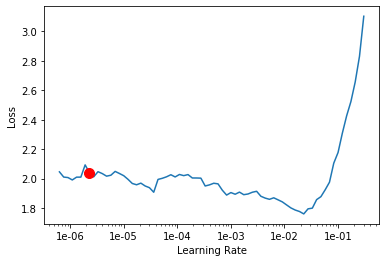

In [10]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-2))
learn.save('food101-test-22-512')

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
# learn.fit_one_cycle(2, max_lr=slice(1e-9, 1e-4))
# learn.save('food101-test-25-512')

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

KeyboardInterrupt: 

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

In [ ]:
interp.most_confused(min_val=5)

In [ ]:
interp.plot_multi_top_losses()

In [ ]:
interp.plot_confusion_matrix(figsize=(20, 20), dpi=200)

### Test Set

In [7]:
bs=24
test_data = (ImageList.from_df(df=test_df, path=path/'images', cols=1)
            .split_none()
            .label_from_df(cols=0)
            .transform(size=512)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

learn = cnn_learner(test_data, model, metrics=accuracy, callback_fns=ShowGraph)
learn.load('food101-test-20-512');

One additional option to improve our model is TTA.

- TTA(Time tested augmentation): 
    - Create multiple augmented copies of each image in the test set. The model will make a prediction for each set, then return an ensemble of those predictions. 

In [8]:
learn.validate(test_data.train_dl)

[0.55672616, tensor(0.8435)]

In [ ]:
# log_preds, y = learn.TTA()
# accuracy(log_preds, y)

The next step for me would be to slightly increase the variance of some of the available transformations, I believe that the model will learn more quickly and become more robust. -- after some experimentation. 

Note that our model struggles with fine grained differences.

The other main area that I would focus on is to fix the mislabeled images, then to view additional options for helping with fine grained differences.  

As we go through our model it's important to get to know the data, and checking on the data intermittently throughout the training process is how we know what is working. 
